## Library

In [283]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_pipe
from sklearn.metrics import classification_report,RocCurveDisplay,roc_auc_score,precision_score,recall_score,f1_score

from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import pickle
import warnings
warnings.filterwarnings('ignore')

## EDA

In [238]:
df=pd.read_csv('D:/Dataset/data_telco_customer_churn.csv')
df

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes


## Latar belakang
### Context
perusahaan telekomunikasi yang banyak bermunculan membuat persaingan semakin tinggi. Sementara untuk customer sendiri hal ini memberikan pilihan dalam memilih provider jasa telekomunkasi sehingga customer yang berpindah antar provider menjadi hal yang wajar dan sering dilakukan terutama jika terjadi perang harga antara provider. Dari sisi perusahaan sendiri mempertahankan customer ialah proses yang memakan biaya dan waktu apalagi jika perusahaan tidak bisa menargetkan mana yang berpotensi churn dan tidak.

### Masalah
Usaha mempertahankan customer bisa memakan biaya dan waktu yang banyak dan akan sia-sia jika usaha dilakukan terhadap customer yang tidak berpotensi churn, oleh karena itu untuk menghemat biaya serta meningkatkan efisiensi perusahaan ingin mengetahui customer mana yang harus diberikan prioritas agar upaya yang dilakukan lebih tertarget dan efisien.

### Goals
short-term:
- menurunkan churn rate sebanyak 5% pada kuartal selanjutnya
- Membuat strategi pemasaran menjadi tertarget dengan bantuan prediksi yang dilakukan oleh model

Long-term:
- Membuat model yang dapat memprediksi customer yang berpotensi churn dengan baik.
### Variables
Variabel independen (features): 
1. Dependents: Apakah seorang customer memiliki tanggungan atau tidak.
2. tenure: Lama customer menggunakan jasa perusahaan dalam hitungan bulan.
3. OnlineSecurity: Apakah seorang customer memiliki online security atau tidak.
4. OnlineBackup: Apakah seorang customer memiliki online backup atau tidak.
5. InternetService: Jenis internet yang digunakan customer
6. DeviceProtection: Apakah customer memiliki perlindungan perangkat atau tidak.
7. TechSupport: Apakah customer memiliki dukungan tech support ataupun tidak.
8. Contract: Tipe kontrak berdasarkan durasi waktu.
9. PaperlessBilling: Apakah tagihan ditagih menggunakan kertas ataupun paperless.
10. MontlyCharges: Jumlah yang dibayarkan oleh customer per bulan.

Variabel dependen (target):
- Churn: keadaan dimana seorang customer berhenti menggunakan jasa perusahaan Telco.

Evaluation metric: ROC-AUC

Dalam mempertahankan customer, perusahaan tentu ingin menghemat biaya dalam melakukan promosi kepada customer, dengan kata lain kita ingin mengurangi munculnya false postive dalam prediksi, tapi tentunya kita ingin agar tidak ada customer yang berpotensi churn yang terlewatkan oleh model, jadi kita ingin model meminimalkan false postive tapi juga tidak terlalu ketat sehingga mengurangi kelas positive, oleh karena itu kita akan menggunakan ROC-AUC sebagai metric evaluasi utama.

## Data

In [239]:
df.isnull().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [240]:
df.duplicated().sum()

77

<Axes: xlabel='Churn', ylabel='count'>

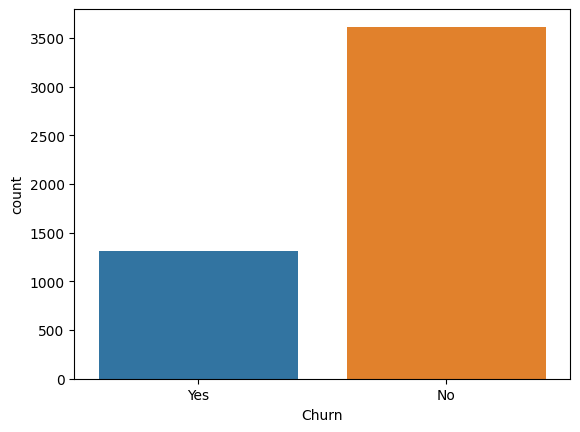

In [241]:
sns.countplot(x=df['Churn'])

In [242]:
df['Churn'].value_counts(normalize=True)

No     0.733063
Yes    0.266937
Name: Churn, dtype: float64

Ternyata dataset ini tidak memiliki missing value, tetapi memiliki data duplikat sebanyak 77 baris dan agak imbalance dengan rasio kelas 73:27

In [243]:
def unival(x):
    
    value=[]
    sum_value=[]
    for i in x.columns:
        value.append(df[i].unique())
        sum_value.append(df[i].nunique())
    uni=pd.DataFrame({'var':df.columns,'counts':sum_value,'unique':value})
    return uni

In [244]:
unival (df)

,var,counts,unique
0,Dependents,2,"[Yes, No]"
1,tenure,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1..."
2,OnlineSecurity,3,"[No, Yes, No internet service]"
3,OnlineBackup,3,"[No, Yes, No internet service]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,3,"[Yes, No internet service, No]"
6,TechSupport,3,"[Yes, No, No internet service]"
7,Contract,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,2,"[Yes, No]"
9,MonthlyCharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7,..."


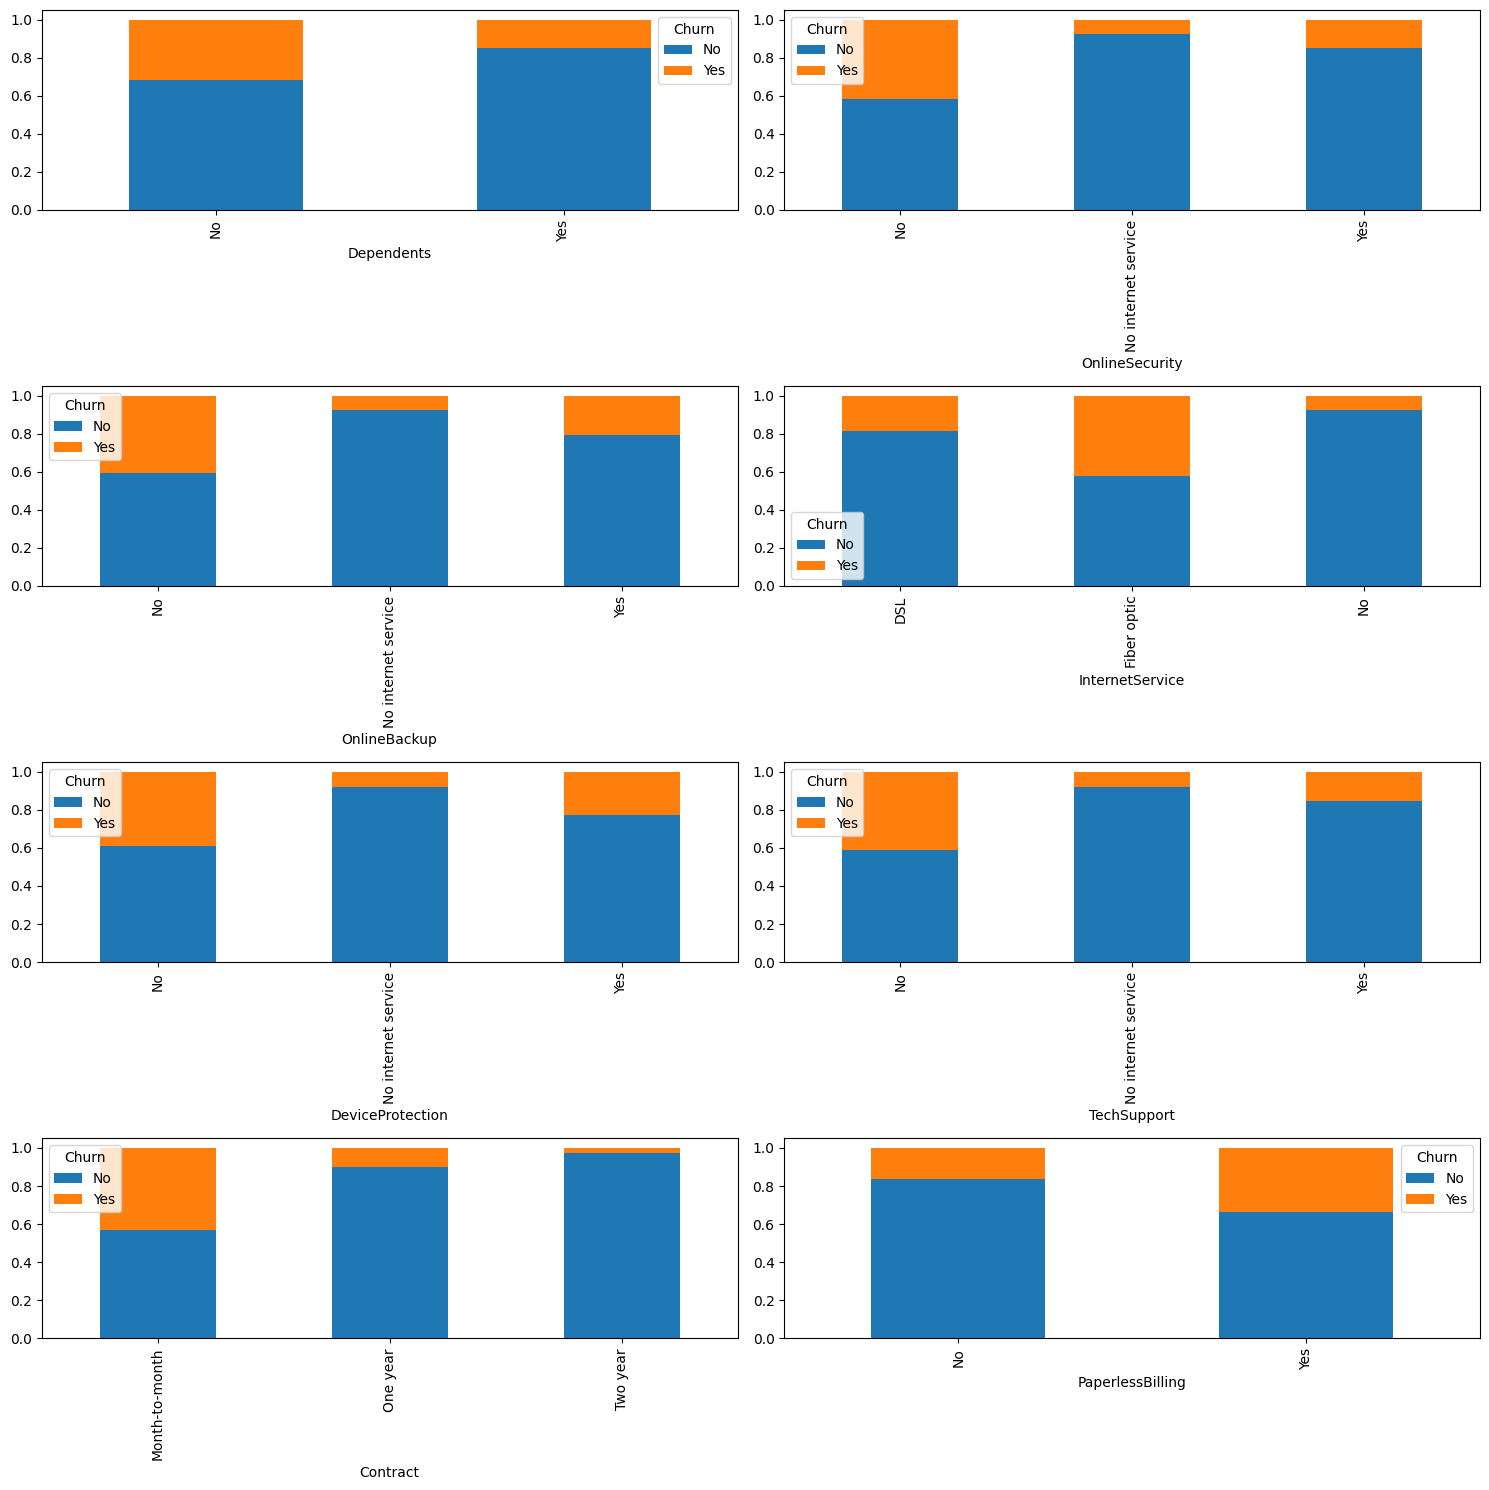

In [245]:
count = 0
fig = plt.figure(figsize=(15,15))

for i in df.drop(columns=['Churn','tenure','MonthlyCharges',]).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['Churn'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

Catatan:
1. Customer yang tidak memiliki `tanggungan` cenderung berhenti menggunakan layanan
2. Customer yang memiliki layanan internet tapi tidak menggunakan `online security` cenderung berhenti menggunakan layanan.
3. Customer yang memiliki layanan internet tapi tidak memiliki `online backup` cenderung berhenti menggunakan layanan.
4. customer yang menggunakan internet `fiber optic` cenderung berhentin menggunakan layanan.
5. Customer yang memiliki layanan internet tapi tidak menggunakan `device protection` cenderung berhenti menggunakan layanan.
6. Customer yang memiliki layanan internet tapi tidak menggunakan `tech support` cenderung berhenti menggunakan layanan.
7. Customer yang menggunakan `kontrak per bulan` cenderung berhenti menggunakan layanan.
8. Customer yang menggunakan `paperless billing` cenderung berhenti menggunakan layanan.

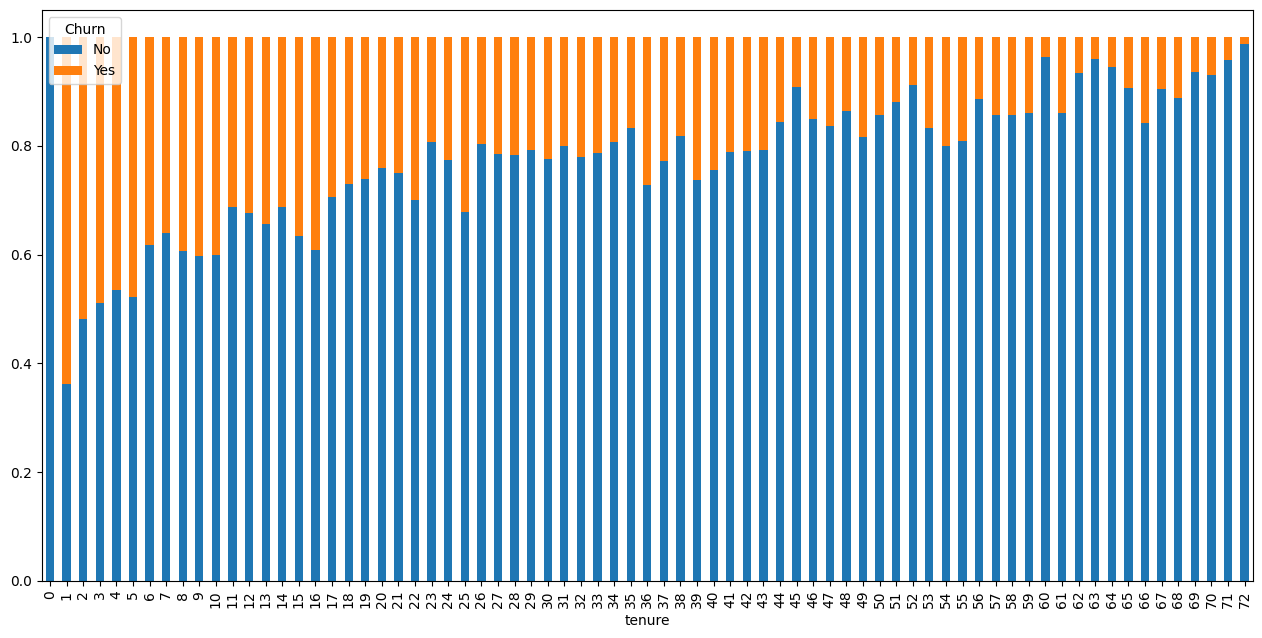

In [246]:
count = 0
fig = plt.figure(figsize=(25,25))

for i in df[['tenure']]:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['Churn'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

Untuk feature tenure sendiri semakin singkat waktu menggunakan layanan semakin tinggi proporsi customer yang berhenti menggunakan layanan.

## Data preprocessing

In [247]:
# Menghapus data duplikat
df.drop_duplicates(inplace=True)

In [248]:
# Mengkonversi kolom yang hanya memiliki 2 value menjadi kelas 1 dan 0
df['Churn']=np.where(df['Churn']=='Yes',1,0)
df['Dependents']=np.where(df['Dependents']=='Yes',1,0)
df['PaperlessBilling']=np.where(df['PaperlessBilling']=='Yes',1,0)

In [249]:
# Menambah feature totalbill berdasarkan feature tenure dikali monthlycharges
df['TotalBill']=df['tenure']*df['MonthlyCharges']

In [250]:
onehot=OneHotEncoder()
robust=RobustScaler()
coltran=ColumnTransformer([
    ('encoding',onehot,['OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','Contract']),
    ('scaling',robust,['MonthlyCharges','TotalBill'])
],remainder='passthrough')

## Splitting data

In [251]:
x=df.drop(columns='Churn')
y=df['Churn']

In [252]:
x_trainval,x_test,y_trainval,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=10)

In [253]:
x_train,x_val,y_train,y_val=train_test_split(x_trainval,y_trainval,test_size=0.25,stratify=y_trainval,random_state=10)

## Benchmarking: Base model

In [254]:
# Define model dan cross validasi

logreg=LogisticRegression()
tree=DecisionTreeClassifier()
knn=KNeighborsClassifier()
svm=SVC(probability=True)
rf=RandomForestClassifier()
xgb=XGBClassifier()
lgbm=lgb.LGBMClassifier()
ada=AdaBoostClassifier()
base=[
    ('tree',tree),
    ('knn',knn),
    ('svm',svm)
]
stack=StackingClassifier(estimators=base)

selector=RFE(estimator=tree,n_features_to_select=0.8)
skfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=10)

In [255]:
model_name=['Logistic Regression','Desicion Tree','K-Neighbors','SVM','Random Forest','XG Boost','Light Gradient Boosting','Adaptive Boost','Stacking']
model=[logreg,tree,knn,svm,rf,xgb,lgbm,ada,stack]
roc_scores=[]
precision_scores=[]

for i in model:
    pipe=Pipeline([
    ('transform',coltran),
    ('selection',selector),
    ('modeling',i)
])
    roc_score=cross_val_score(pipe,x_train,y_train,cv=skfold,scoring='roc_auc')
    roc_scores.append(roc_score.mean())
    
benchmark=pd.DataFrame({'Model':model_name,'roc score':roc_scores})   


In [256]:
benchmark

,Model,roc score
0,Logistic Regression,0.847069
1,Desicion Tree,0.659619
2,K-Neighbors,0.778655
3,SVM,0.798237
4,Random Forest,0.802090
5,XG Boost,0.813051
6,Light Gradient Boosting,0.821787
7,Adaptive Boost,0.842988
8,Stacking,0.806438


Untuk benchmark pertama sebelum tuning dan balancing, model dengan skor terbaik adalah Logistic Regression.

## Base model evaluation

In [257]:
mean_validation=[]
for i in model:
    pipe=Pipeline([
    ('transform',coltran),
    ('selection',selector),
    ('modeling',i)
])
    pipe.fit(x_train,y_train)
    y_pred=pipe.predict_proba(x_val)[:,1]
    score=roc_auc_score(y_val,y_pred)
    mean_validation.append(score.mean())
benchmark['Validation Score']=mean_validation

In [258]:
benchmark

,Model,roc score,Validation Score
0,Logistic Regression,0.847069,0.831118
1,Desicion Tree,0.659619,0.635455
2,K-Neighbors,0.778655,0.762517
3,SVM,0.798237,0.789820
4,Random Forest,0.802090,0.805245
5,XG Boost,0.813051,0.804788
6,Light Gradient Boosting,0.821787,0.820202
7,Adaptive Boost,0.842988,0.833222
8,Stacking,0.806438,0.795185


Setelah di evaluasi pada data validasi, ternyata model adaboost lebih stabil dibanding logistic regression dimana terjadi penurunan performa pada kedua model, tetapi logistic regression memiliki penurunan lebih banyak dibanding adaboost.

Selanjutnya mari kita lihat performa model setelah di balancing.

## Benchmarking: Balancing with oversampling

In [259]:
smote=SMOTE(random_state=10)
model_name=['Logistic Regression','Desicion Tree','K-Neighbors','SVM','Random Forest','XG Boost','Light Gradient Boosting','Adaptive Boost','Stacking']
model=[logreg,tree,knn,svm,rf,xgb,lgbm,ada,stack]
mean_score=[]

for i in model:
    pipe=imb_pipe([
    ('transform',coltran),
    ('selection',selector),
    ('resample',smote),
    ('modeling',i)
])
    score=cross_val_score(pipe,x_train,y_train,cv=skfold,scoring='roc_auc')
    mean_score.append(score.mean())

benchmark['Balancing score']=mean_score
 



In [260]:
benchmark

,Model,roc score,Validation Score,Balancing score
0,Logistic Regression,0.847069,0.831118,0.845803
1,Desicion Tree,0.659619,0.635455,0.668889
2,K-Neighbors,0.778655,0.762517,0.761367
3,SVM,0.798237,0.789820,0.834778
4,Random Forest,0.802090,0.805245,0.801448
5,XG Boost,0.813051,0.804788,0.815982
6,Light Gradient Boosting,0.821787,0.820202,0.823586
7,Adaptive Boost,0.842988,0.833222,0.844887
8,Stacking,0.806438,0.795185,0.801420


Setelah di balancing model dengan performa terbaik menjadi adaboost, selanjutnya mari kita evaluasi.

## Model evaluation with balancing

In [261]:
mean_validation=[]
for i in model:
    pipe=imb_pipe([
    ('transform',coltran),
    ('selection',selector),
    ('resample',smote),
    ('modeling',i)
])
    pipe.fit(x_train,y_train)
    y_pred=pipe.predict_proba(x_val)[:,1]
    score=roc_auc_score(y_val,y_pred)
    mean_validation.append(score.mean())
benchmark['Balancing Validation']=mean_validation

In [262]:
benchmark

,Model,roc score,Validation Score,Balancing score,Balancing Validation
0,Logistic Regression,0.847069,0.831118,0.845803,0.831770
1,Desicion Tree,0.659619,0.635455,0.668889,0.642647
2,K-Neighbors,0.778655,0.762517,0.761367,0.756162
3,SVM,0.798237,0.789820,0.834778,0.820442
4,Random Forest,0.802090,0.805245,0.801448,0.816152
5,XG Boost,0.813051,0.804788,0.815982,0.810325
6,Light Gradient Boosting,0.821787,0.820202,0.823586,0.821964
7,Adaptive Boost,0.842988,0.833222,0.844887,0.836141
8,Stacking,0.806438,0.795185,0.801420,0.805411


Terlihat setelah di balancing, ternyata adaboost dan logistic regression memiliki performa yang hampir mirip baik pada data training maupun validation. Oleh karena itu, kita akan mencoba melakukan tuning pada kedua model untuk melihat apakah akan ada peningkatan performa pada satu atau kedua model.

## Hyperparameter Tuning: Logistic Regression

In [263]:
parameter={
    'modeling__C':[500,250,100,50,25,10,1,0.1,0.5,0.01],
    'modeling__penalty':['l1','l2',None,'elasticnet'],
    'modeling__solver':['bfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'modeling__random_state':[10]
}

log_pipe=imb_pipe([
    ('transform',coltran),
    ('selection',selector),
    ('resample',smote),
    ('modeling',logreg)
])


In [264]:
grid=GridSearchCV(log_pipe,param_grid=parameter,scoring='roc_auc',cv=skfold,n_jobs=-1)

In [265]:
grid.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(),
                                                                         ['OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'InternetService',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'Contract']),
                                                                        ('scaling',
                                                                         RobustScaler(),
                                                                         ['MonthlyCharges',
                                                                          'TotalBill'])...
                                            n_features_to_select=0.8)),
                                       ('resample', SMOTE(random_state=10)),
                                       ('modeling', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'modeling__C': [500, 250, 100, 50, 25, 10, 1, 0.1, 0.5,
                                         0.01],
                         'modeling__penalty': ['l1', 'l2', None, 'elasticnet'],
                         'modeling__random_state': [10],
                         'modeling__solver': ['bfgs', 'liblinear', 'newton-cg',
                                              'newton-cholesky', 'sag',
                                              'saga']},
             scoring='roc_auc')

In [266]:
print(grid.best_params_)
print(grid.best_score_)

{'modeling__C': 0.1, 'modeling__penalty': 'l2', 'modeling__random_state': 10, 'modeling__solver': 'sag'}
0.8463218895966861


In [267]:
best_logreg=grid.best_estimator_
best_logreg.fit(x_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding', OneHotEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract']),
                                                 ('scaling', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalBill'])])),
                ('selection',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=0.8)),
                ('resample', SMOTE(random_state=10)),
                ('modeling',
                 LogisticRegression(C=0.1, random_state=10, solver='sag'))])

In [268]:
log_pipe.fit(x_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding', OneHotEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract']),
                                                 ('scaling', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalBill'])])),
                ('selection',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=0.8)),
                ('resample', SMOTE(random_state=10)),
                ('modeling', LogisticRegression())])

In [269]:
# Define wadah yang berisi list untuk dataframe
precision_before=[]
precision_after=[]
recall_before=[]
recall_after=[]
f1_before=[]
f1_after=[]
roc_before=[]
roc_after=[]

# Prediksi
y_base_pred=log_pipe.predict(x_val)
y_best_pred=best_logreg.predict(x_val)
y_base_pred_prob=log_pipe.predict_proba(x_val)[:,1]
y_best_pred_prob=best_logreg.predict_proba(x_val)[:,1]

# Proses scoring
base_roc=roc_auc_score(y_val,y_base_pred_prob)
best_roc=roc_auc_score(y_val,y_best_pred_prob)
base_precision=precision_score(y_val,y_base_pred)
best_precision=precision_score(y_val,y_best_pred)
base_recall=recall_score(y_val,y_base_pred)
best_recall=recall_score(y_val,y_best_pred)
base_f1=f1_score(y_val,y_base_pred)
best_f1=f1_score(y_val,y_best_pred)

# Memasukkan hasil score ke dalam wadah
roc_before.append(base_roc)
roc_after.append(best_roc)
precision_before.append(base_precision)
precision_after.append(best_precision)
recall_before.append(base_recall)
recall_after.append(best_recall)
f1_before.append(base_f1)
f1_after.append(best_f1)

In [270]:
y_base_pred=log_pipe.predict(x_val)
precision_score(y_val,y_base_pred)
print(classification_report(y_val,y_base_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79       713
           1       0.49      0.77      0.60       258

    accuracy                           0.72       971
   macro avg       0.69      0.74      0.69       971
weighted avg       0.79      0.72      0.74       971



## Hyperparameter Tuning: Adaboost

In [271]:
# Define pipeline dan parameter yang akan dituning
parameter={
    'modeling__estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],
    'modeling__n_estimators':[1,5,10,25,50,100,250,500],
    'modeling__learning_rate':[2,1.5,1,0.5,0.1],
    'modeling__random_state':[10]
}

ada_pipe=imb_pipe([
    ('transform',coltran),
    ('selection',selector),
    ('resample',smote),
    ('modeling',ada)
])

In [272]:
grid=GridSearchCV(ada_pipe,param_grid=parameter,scoring='roc_auc',cv=skfold,n_jobs=-1)

In [273]:
grid.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(),
                                                                         ['OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'InternetService',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'Contract']),
                                                                        ('scaling',
                                                                         RobustScaler(),
                                                                         ['MonthlyCharges',
                                                                          'TotalBill'])...
                                       ('resample', SMOTE(random_state=10)),
                                       ('modeling', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'modeling__estimator': [DecisionTreeClassifier(max_depth=1),
                                                 DecisionTreeClassifier(max_depth=2),
                                                 DecisionTreeClassifier(max_depth=3)],
                         'modeling__learning_rate': [2, 1.5, 1, 0.5, 0.1],
                         'modeling__n_estimators': [1, 5, 10, 25, 50, 100, 250,
                                                    500],
                         'modeling__random_state': [10]},
             scoring='roc_auc')

In [274]:
print(grid.best_params_)
print(grid.best_score_)

{'modeling__estimator': DecisionTreeClassifier(max_depth=1), 'modeling__learning_rate': 0.5, 'modeling__n_estimators': 25, 'modeling__random_state': 10}
0.8486941271438051


Setelah dituning, performa model hanya mengalami peningkatan yang tidak begitu berarti. Selanjutnya mari kita bandingkan performa model sebelum dan sesudah dituning pada data validasi.

In [275]:
best_ada=grid.best_estimator_
best_ada.fit(x_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding', OneHotEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract']),
                                                 ('scaling', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalBill'])])),
                ('selection',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=0.8)),
                ('resample', SMOTE(random_state=10)),
                ('modeling',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.5, n_estimators=25,
                                    random_state=10))])

In [276]:
ada_pipe.fit(x_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding', OneHotEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract']),
                                                 ('scaling', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalBill'])])),
                ('selection',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=0.8)),
                ('resample', SMOTE(random_state=10)),
                ('modeling', AdaBoostClassifier())])

In [277]:
#prediksi
y_base_pred=ada_pipe.predict(x_val)
y_best_pred=best_ada.predict(x_val)
y_base_pred_prob=ada_pipe.predict_proba(x_val)[:,1]
y_best_pred_prob=best_ada.predict_proba(x_val)[:,1]

#scoring
base_roc=roc_auc_score(y_val,y_base_pred_prob)
best_roc=roc_auc_score(y_val,y_best_pred_prob)
base_precision=precision_score(y_val,y_base_pred)
best_precision=precision_score(y_val,y_best_pred)
base_recall=recall_score(y_val,y_base_pred)
best_recall=recall_score(y_val,y_best_pred)
base_f1=f1_score(y_val,y_base_pred)
best_f1=f1_score(y_val,y_best_pred)

# Penambahan hasil scoring 
roc_before.append(base_roc)
roc_after.append(best_roc)
precision_before.append(base_precision)
precision_after.append(best_precision)
recall_before.append(base_recall)
recall_after.append(best_recall)
f1_before.append(base_f1)
f1_after.append(best_f1)

# Membuat dataframe berisikan skor
eval_name=['Logistic Regression','Adaboost']
evaluation=pd.DataFrame({'Model':eval_name,
                         'ROC Before':roc_before,'ROC After':roc_after,
                         'Precision Before':precision_before,'Precision After':precision_after,
                         'Recall Before':recall_before,'Recall After':recall_after,
                         'f1 Before':f1_before,'f1 After':f1_after})


In [278]:
evaluation

,Model,ROC Before,ROC After,Precision Before,Precision After,Recall Before,Recall After,f1 Before,f1 After
0,Logistic Regression,0.830982,0.829906,0.486553,0.495074,0.771318,0.779070,0.596702,0.605422
1,Adaboost,0.836141,0.829868,0.536023,0.506562,0.720930,0.748062,0.614876,0.604069


Ternyata setelah dituning, ada perubahan pada beberapa metric pada kedua model:
1. Logistic Regression: nilai ROC AUC setelah dituning menjadi menurun begitu pula dengan nilai f1, untuk nilai precision dan recall perubahan tidak terlalu signifikan.
2. Adaboost: nilai precision terjadi penurunan sedangkan nilai recall mengalami peningkatan setelah dituning, untuk nilai ROC AUC dan f1 perubahan tidak terlalu signifikan.

Disini  metric utama yang akan digunakan adalah nilai ROC AUC, oleh karena itu kita akan menggunakan model Adaboost yang belum dituning sebagai final model.

## Final model evaluation

In [279]:
y_pred_final_prob=ada_pipe.predict_proba(x_test)[:,1]
y_pred_final=ada_pipe.predict(x_test)

final_roc=roc_auc_score(y_test,y_pred_final_prob)
final_precision=precision_score(y_test,y_pred_final)
final_recall=recall_score(y_test,y_pred_final)
final_f1=f1_score(y_test,y_pred_final)

score_name=['ROC AUC','Precision','Recall','f1']
score=[final_roc,final_precision,final_recall,final_f1]

final=pd.DataFrame({'Score name':score_name,'score':score})

In [280]:
final

,Score name,score
0,ROC AUC,0.840161
1,Precision,0.549550
2,Recall,0.709302
3,f1,0.619289


## Feature importance

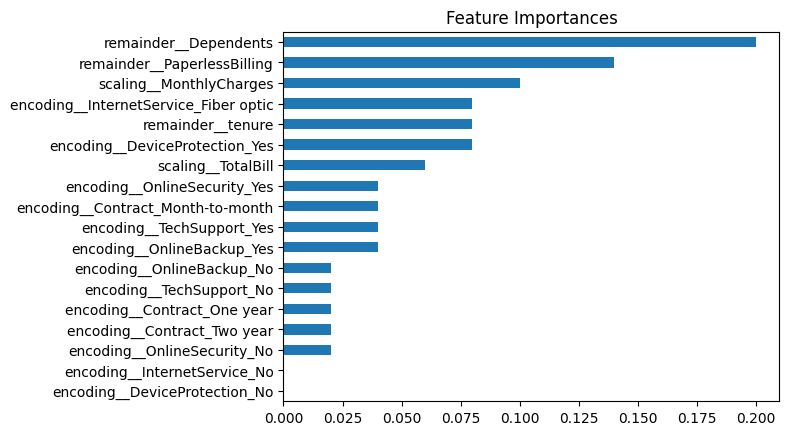

In [281]:

feat_importance=pd.Series(ada_pipe['modeling'].feature_importances_,ada_pipe[:-1].get_feature_names_out()).sort_values()
feat_importance.plot(kind='barh', title='Feature Importances')
plt.show()

Feature yang paling berpengaruh dari model ini adalah dependents, diikuti oleh paperless billing, dan tenure. Namun ada juga feature yang kurang berpengaruh dimana kebanyakan adalah dummy variabel hasil encoding, seperti techsupport(No),onlinebackup(Yes), dan DeviceProtection(No internet service).

## Conclusion and Recommendation

In [282]:
final

,Score name,score
0,ROC AUC,0.840161
1,Precision,0.549550
2,Recall,0.709302
3,f1,0.619289


Berdasarkan hasil performa pada data testing, kita dapat menyimpulkan beberapa hal:
1. Berdasarkan nilai ROC AUC, model dapat membedakan customer yang berpotensi churn dan yang tidak dengan cukup baik dan akurat.
2. Berdasarkan nilai precision, model memiliki ketepatan dalam memprediksi customer yang benar-benar berpotensi churn sebesar 54% 
3. Berdasarkan nilai recall, model dapat memprediksi customer yang berpotensi churn sebesar 72% terlepas customer tersebut benar-benar berpotensi churn atau tidak, jika dihubungkan dengan nilai precision maka ada 18% prediksi customer yang tidak berpotensi churn tapi dianggap berpotensi.
4. Berdasarkan nilai f1, jika ingin menyeimbangkan antara recall dan precision, maka model dapat memprediksi sebesar 62% dengan mempertimbangkan recall dan precision.

Model ini dapat membantu mengidentifikasi customer yang berpotensi churn dengan baik, hal ini dapat membantu tim marketing dalam memilah mana customer yang harus diprioritaskan saat melakukan penawaran, sehingga hal ini dapat membantu menghemat biaya karena tentu dengan adanya prediksi tidak semua customer yang diberikan penawaran dan treatment yang lebih. Dengan begini jika perusahaan ingin mengurangi churn rate hingga 5% untuk kuartal berikutnya sebagai tujuan jangka pendek bisa saja dilakukan.

Akan tetapi untuk saat ini ada beberapa batasan yang dimiliki oleh model ini, seperti dalam melakukan prediksi model masih belum mampu memprediksi dengan nilai probabilitas > 0.6, dimana artinya model masih terlalu 'hati-hati' dalam melakukan prediksi, dimana jika model mampu memprediksi lebih dari itu kita dapat melakukan kategorisasi berdasarkan nilai probabilitas mana customer yang prioritas tinggi, sedang, dan rendah. Selain itu ada banyak feature yang memiliki nilai feature importances sehingga kurang atau bahkan tidak berpengaruh, hal ini bisa terjadi karena model kurang mampu menangkap pola yang ada dari feature ini atau mungkin saja feature ini tidak relevan, dan terakhir ukuran dataset untuk training model masih terlalu kecil

### Recommendation
1. Melakukan promosi dan penawaran spesial kepada customer yang diprediksi churn untuk membuat mereka bertahan.
2. Memberikan penawaran layanan tambahan atau add-ons untuk customer yang berpotensi rendah untuk churn.
3. Melakukan survey dan membuka customer feedback dari segi add-ons dimana banyak customer yang berpotensi churn tidak menggunakan add-ons seperti online security dan online backup.
4. Memperbesar dataset untuk kedepannya dan menambah feature baru yang bisa meningkatkan kinerja model.
